<a href="https://colab.research.google.com/github/fawadmehboob/Adaptive-Control-of-a-2D-Segway-Robot/blob/main/SegWay_adaptive_Link_friction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Plant

In [2]:
class SegwayPlant:
    def __init__(self, z0, theta):
        """
        Initialize the Segway with initial state z0 = [x, x_dot, phi, phi_dot] and unknown friction theta.
        """
        self.z = z0  # [x, x_dot, phi, phi_dot]
        self.theta = theta  # Unknown friction coefficient (rotational damping at pivot)
        # Segway parameters
        self.m1 = 1.0  # Mass of the link
        self.m2 = 0.5  # Mass of the wheel
        self.I1 = 0.1  # Moment of inertia of the link
        self.I2 = 0.05  # Moment of inertia of the wheel
        self.l = 1.0  # Length of the link
        self.R = 0.2  # Radius of the wheel
        self.g = 9.81  # Gravity
        # Derived constants
        self.M = self.m1 + self.m2 + self.I2 / (self.R ** 2)
        self.I = self.I1 + self.m1 * (self.l / 2) ** 2
        self.C = self.m1 * (self.l / 2)

    def dynamics(self, T):
        """
        Compute the state derivatives dz/dt = f(z, T).
        Friction acts as a torque in phi-dynamics: -theta * phi_dot
        """
        x, x_dot, phi, phi_dot = self.z
        # Mass matrix
        D = np.array([
            [self.M, self.C * np.cos(phi)],
            [self.C * np.cos(phi), self.I]
        ])
        # Nonlinear and friction terms (friction in phi-dynamics)
        f = np.array([
            self.C * phi_dot**2 * np.sin(phi),  # No friction in x-dynamics
            self.C * self.g * np.sin(phi) - self.theta * phi_dot  # Friction torque in phi-dynamics
        ])
        # Input terms
        u = np.array([T / self.R, -T])
        # Solve for accelerations
        accel = np.linalg.solve(D, u + f)
        dz = np.array([x_dot, accel[0], phi_dot, accel[1]])
        return dz

    def update(self, T, dt):
        """
        Update the state using Euler integration.
        """
        dz = self.dynamics(T)
        self.z += dz * dt
        return self.z


# Adaptive Controller

In [7]:
class AdaptiveController:
    def __init__(self, p, theta_hat0, k1, k2, k3, k4):
        """
        Initialize the adaptive controller.
        """
        self.p = p  # Design parameter for adaptation
        self.theta_hat = theta_hat0  # Initial estimate of theta
        self.k1 = k1  # Sliding surface gain for x
        self.k2 = k2  # Sliding surface gain for x_dot
        self.k3 = k3  # Sliding surface gain for phi
        self.k4 = k4  # Sliding surface gain for phi_dot
        # Segway parameters (needed for control law)
        self.m1 = 1.0
        self.m2 = 0.5
        self.I1 = 0.1
        self.I2 = 0.05
        self.l = 1.0
        self.R = 0.2
        self.g = 9.81
        self.M = self.m1 + self.m2 + self.I2 / (self.R ** 2)
        self.I = self.I1 + self.m1 * (self.l / 2) ** 2
        self.C = self.m1 * (self.l / 2)

    def compute_control(self, z):
        """
        Compute the control torque T.
        """
        x, x_dot, phi, phi_dot = z
        # Sliding surface
        s = self.k1 * x + self.k2 * x_dot + self.k3 * phi + self.k4 * phi_dot
        # Denominator term
        denom = self.k2 * (self.I / self.R + self.C) - self.k4 * (self.C / self.R + self.M)
        # Terms in the control law
        term1 = self.p * s
        term2 = self.k1 * x_dot + self.k3 * phi_dot
        term3 = (self.C * self.g / (self.M * self.I - self.C**2)) * (-self.k2 * self.C + self.k4 * self.M) * phi
        term4 = (self.theta_hat / (self.M * self.I - self.C**2)) * (self.k2 * self.C - self.k4 * self.M) * phi_dot
        # Control law
        T = -((self.M * self.I - self.C**2) * (term1 + term2 + term3 + term4)) / denom
        return T

    def update_theta_hat(self, s, phi_dot, dt):
        """
        Update theta_hat using d(theta_hat)/dt = - (s / (M*I - C^2)) * (k2*C - k4*M) * phi_dot.
        """
        dtheta_hat = -(s / (self.M * self.I - self.C**2)) * (self.k2 * self.C - self.k4 * self.M) * phi_dot
        self.theta_hat += dtheta_hat * dt
        return self.theta_hat


# Simulation

In [3]:
class SegwaySimulation:
    def __init__(self, plant, controller, t_max, dt):
        """
        Initialize simulation.
        """
        self.plant = plant
        self.controller = controller
        self.t_max = t_max
        self.dt = dt
        self.time = np.arange(0, t_max, dt)
        self.z_history = []
        self.theta_hat_history = []
        self.T_history = []

    def run(self):
        """
        Run the simulation.
        """
        for t in self.time:
            z = self.plant.z
            x, x_dot, phi, phi_dot = z
            # Compute sliding surface
            s = self.controller.k1 * x + self.controller.k2 * x_dot + self.controller.k3 * phi + self.controller.k4 * phi_dot
            # Compute control and update theta_hat
            T = self.controller.compute_control(z)
            theta_hat = self.controller.update_theta_hat(s, phi_dot, self.dt)
            z_new = self.plant.update(T, self.dt)
            self.z_history.append(z_new.copy())
            self.theta_hat_history.append(theta_hat)
            self.T_history.append(T)

    def plot_results(self):
        """
        Plot the state, theta_hat, and control.
        """
        z_history = np.array(self.z_history)
        plt.figure(figsize=(12, 8))
        plt.subplot(4, 1, 1)
        plt.plot(self.time, z_history[:, 0], label='x')
        plt.axhline(0, color='k', linestyle='--', alpha=0.3)
        plt.ylabel('Position x')
        plt.grid(True)
        plt.legend()
        plt.subplot(4, 1, 2)
        plt.plot(self.time, z_history[:, 2], label='phi')
        plt.axhline(0, color='k', linestyle='--', alpha=0.3)
        plt.ylabel('Angle phi')
        plt.grid(True)
        plt.legend()
        plt.subplot(4, 1, 3)
        plt.plot(self.time, self.theta_hat_history, label='theta_hat')
        plt.axhline(self.plant.theta, color='r', linestyle='--', label='True theta')
        plt.ylabel('Theta_hat')
        plt.grid(True)
        plt.legend()
        plt.subplot(4, 1, 4)
        plt.plot(self.time, self.T_history, label='Torque T')
        plt.xlabel('Time (s)')
        plt.ylabel('Torque T')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


# Animator

In [4]:
class SegwayAnimator:
    def __init__(self, sim):
        """
        Initialize the animator with simulation data.
        """
        self.sim = sim
        self.z_history = np.array(sim.z_history)
        self.R = sim.plant.R
        self.l = sim.plant.l
        self.dt = sim.dt
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        # Adjust limits to ensure the entire Segway is visible
        max_x = max(abs(self.z_history[:, 0].min()), abs(self.z_history[:, 0].max()))
        self.max_x = max(max_x + 1, 2)  # Ensure minimum range for visibility
        self.times = sim.time

    def init_animation(self):
        """
        Initialize the animation.
        """
        self.ax.set_xlim(-self.max_x, self.max_x)
        self.ax.set_ylim(-0.5, self.l + 0.5)
        self.ax.set_xlabel('X Position')
        self.ax.set_ylabel('Y Position')
        self.ax.grid(True)
        self.ax.set_aspect('equal')
        self.ax.set_title("Segway Balancing Animation")
        # Ground line
        self.ax.axhline(0, color='black', label='Ground')
        # Wheel and link
        self.wheel, = self.ax.plot([], [], 'o', markersize=10, label='Wheel')
        self.link, = self.ax.plot([], [], 'r-', lw=3, label='Link')
        self.ax.legend()
        return self.wheel, self.link

    def update_animation(self, frame):
        """
        Update the animation for each frame.
        """
        x = self.z_history[frame, 0]
        phi = self.z_history[frame, 2]
        # Wheel position (center of the wheel)
        wheel_x = x
        wheel_y = self.R
        # Link position (from wheel center to top of the link)
        link_x = [x, x + self.l * np.sin(phi)]
        link_y = [self.R, self.R + self.l * np.cos(phi)]
        # Update plots
        self.wheel.set_data([wheel_x], [wheel_y])
        self.link.set_data(link_x, link_y)
        return self.wheel, self.link

    def animate(self):
        """
        Create the animation and return an HTML5 video.
        """
        anim = FuncAnimation(self.fig, self.update_animation, frames=len(self.times),
                             init_func=self.init_animation, interval=1000*self.dt, blit=True)
        # Close the figure to prevent static display
        plt.close(self.fig)
        return HTML(anim.to_html5_video())


# RUN

In [5]:
def run_simulation():
    """
    Run the simulation and animation.
    """
    # Initial conditions
    z0 = np.array([0.0, 0.0, np.pi/6, 0.0])  # [x, x_dot, phi, phi_dot]
    theta = 0.5  # Unknown friction coefficient (rotational damping)
    # Controller parameters
    p = 1.0
    theta_hat0 = 0.0
    k1 = 0.9
    k2 = 1.0
    k3 = 1.0
    k4 = 0.5
    # Simulation parameters
    t_max = 10.0
    dt = 0.01
    # Initialize system
    plant = SegwayPlant(z0, theta)
    controller = AdaptiveController(p, theta_hat0, k1, k2, k3, k4)
    sim = SegwaySimulation(plant, controller, t_max, dt)
    # Run simulation
    sim.run()
    # Plot results
    sim.plot_results()
    # Animate
    animator = SegwayAnimator(sim)
    return animator.animate()


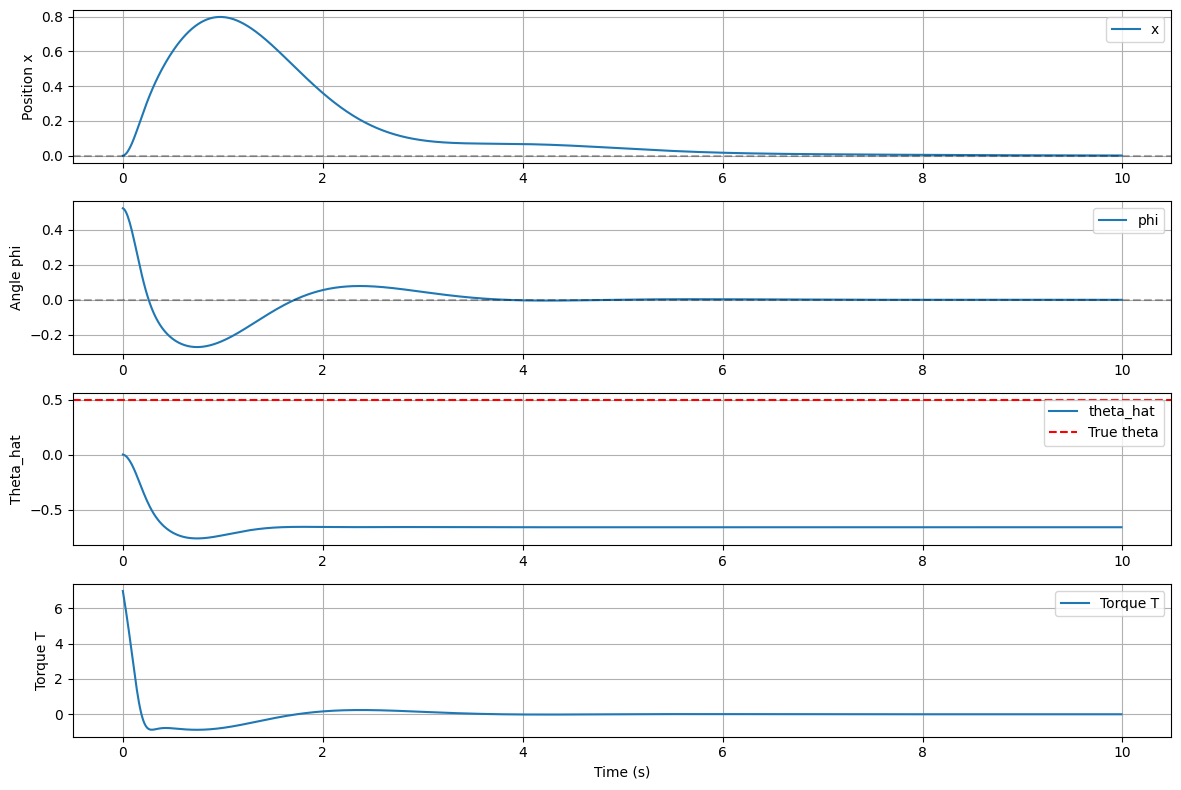

In [8]:
run_simulation()